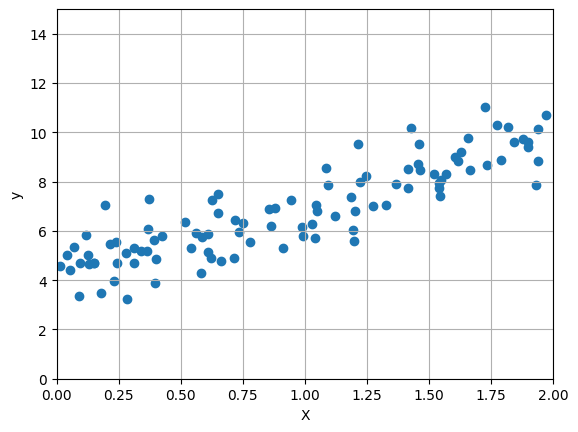

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

m = 100
X = 2 * np.random.rand(m, 1)  # col vector
y = 4 + 3 * X + np.random.randn(m, 1)


plt.scatter(X, y)

plt.xlabel('X')
plt.ylabel('y')

plt.ylim(0, 15)
plt.xlim(0.00, 2.00)

plt.grid()

plt.show()

In [2]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
# try out the Normal equation to solve Linear Regression
# theta = (X^T x X)^-1 x X^T x y
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y


print(theta_best)  # very close to the theta0 = 4 and theta1 = 3

X_new = np.array([ [0], [2] ])
X_new_b = add_dummy_feature(X_new)
y_pred = X_new_b @ theta_best
print(y_pred)

[[4.21509616]
 [2.77011339]]
[[4.21509616]
 [9.75532293]]


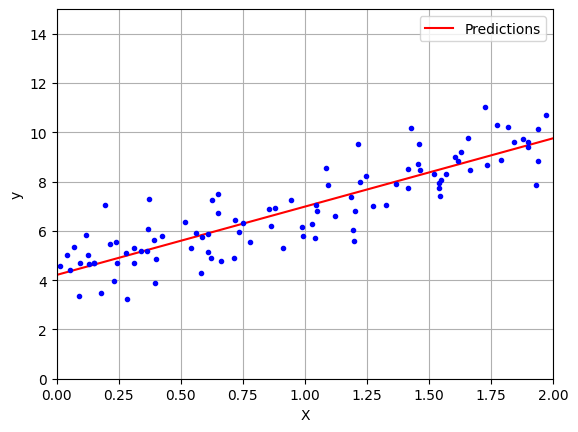

In [3]:
plt.plot(X_new, y_pred, 'r-', label='Predictions')
plt.plot(X, y, 'b.')

plt.legend()
plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(0, 15)
plt.xlim(0.00, 2.00)

plt.show()

In [4]:
# using sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.21509616] [[2.77011339]]
[[4.21509616]
 [9.75532293]]


In [5]:
# LinearRegression class is based on scipy.lingal.lstsq ("least squares")
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

# lstsq computes X+ x y
# X+ is the Moore-Penrose inverse/pseudoinverse of X
print(np.linalg.pinv(X_b) @ y)

# the pseudoinverse is computed using Singular Value Decomposition (np.linalg.svd)
# which decomposes X into U, E, V
# pseudoinverse is then X+ = V x E+ x U^T
# for E+, zero out all values in E that are smaller than a tiny threshold, then replace all non-zero with their inverse and then transpose the matrix

# this works faster than computing the Normal equation directly + handles edge cases (e.g. when "X^T x X" is not invertible)


[[4.21509616]
 [2.77011339]]
[[4.21509616]
 [2.77011339]]


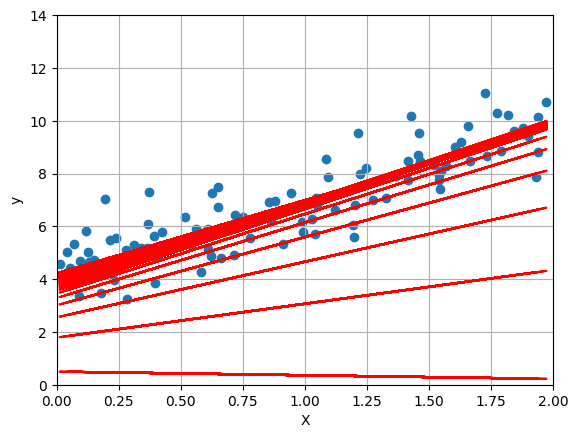

[[4.21509616]
 [2.77011339]]


In [6]:
# Normal equation and SVD are linear wrt number of instances, good for large training sets that can fit in memory
# if the number of features is very large, then don't use Normal equation

# using GD
eta = 0.1  # learning rate
n_epochs = 1_000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure()
plt.scatter(X, y)
for epoch in range(n_epochs):
    y_hat = X_b @ theta
    diff = y_hat - y
    grads = 2 / m * X_b.T @ diff
    theta -= eta * grads

    plt.plot(X, y_hat, 'r')

plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(0, 14)
plt.xlim(0.00, 2.0)
plt.show()

print(theta)

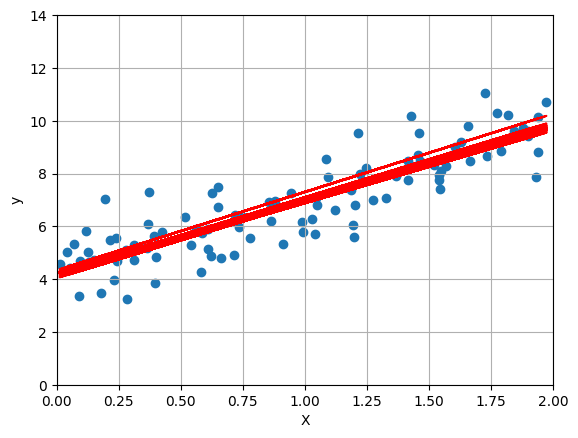

[[4.21076011]
 [2.74856079]]


In [7]:
# using SGD
eta = 0.1
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparams
m = len(X_b)

def learning_schedule(t): return t0 / (t + t1)
np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure()
plt.scatter(X, y)
for epoch in range(n_epochs):
    for iter_ in range(m):
        # randomly pick 1 instance
        rand_idx = np.random.randint(m)
        xi = X_b[rand_idx : rand_idx + 1]
        yi = y[rand_idx : rand_idx + 1]

        y_hat_i = xi @ theta
        diff = y_hat_i - yi
        
        grads = 2 * xi.T @ diff  # don't divide by m for SGD
        eta = learning_schedule(epoch * m + iter_)
        
        theta -= eta*grads

    plt.plot(X, X_b @ theta, 'r')

plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(0, 14)
plt.xlim(0.00, 2.0)
plt.show()

print(theta)

In [8]:
# using sklearn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1_000,
                       # stop if loss falls below "tol" during "n_iter_no_change"
                       tol=1e-5,
                       # no regularization (penalty)
                       penalty=None,
                       eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # ravel() cuz fit expects 1D target

print(sgd_reg.intercept_, sgd_reg.coef_)

[4.21278812] [2.77270267]


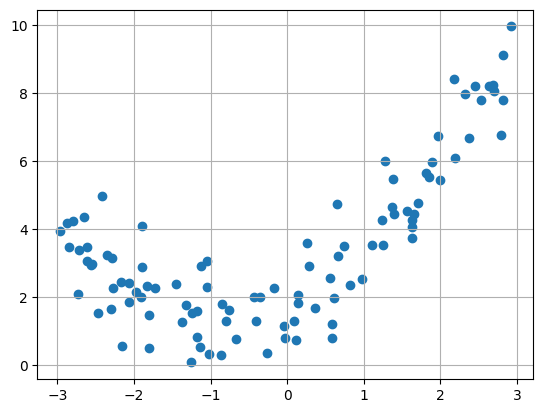

In [12]:
# polynomial regression

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y)
plt.grid()
plt.show()

In [32]:
from sklearn.preprocessing import PolynomialFeatures

# add polynomial features
# degree "d" with "n" features gives array of (n+1)!/(d!n!) features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


In [33]:
lr = LinearRegression()
lr.fit(X_poly, y)
print(lr.intercept_)
print(lr.coef_)

[1.78134581]
[[0.93366893 0.56456263]]


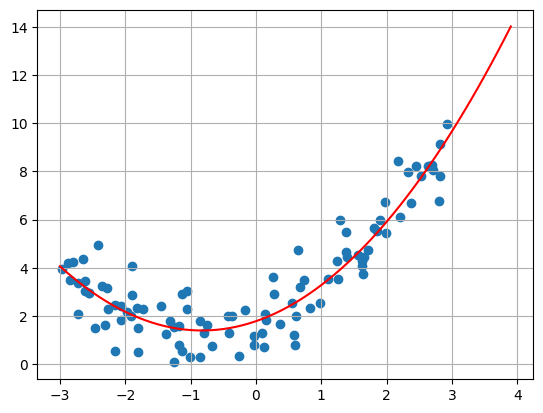

In [34]:
plt.scatter(X, y)

X_plot = np.arange(-3, 4, 0.1).reshape((-1, 1))
X_plot_poly = poly_features.transform(X_plot)
plt.plot(X_plot, lr.predict(X_plot_poly), 'r')
plt.grid()
plt.show()

In [37]:
# learning curves to look for underfitting or overfitting
from sklearn.model_selection import learning_curve

tr_sizes, tr_scores, val_scores = learning_curve(
    LinearRegression(),
    X, y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring='neg_root_mean_squared_error'
)

tr_errs = -tr_scores.mean(axis=1)
val_errs = -val_scores.mean(axis=1)

In [47]:
def plot_learning_curve(tr_sizes, tr_errs, val_errs):
    plt.plot(tr_sizes, tr_errs, 'r-+', linewidth=2, label='train')
    plt.plot(tr_sizes, val_errs, 'b-', linewidth=3, label='valid')
    
    plt.grid()
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')

    plt.ylim(0.0, 3.0)
    
    plt.show()

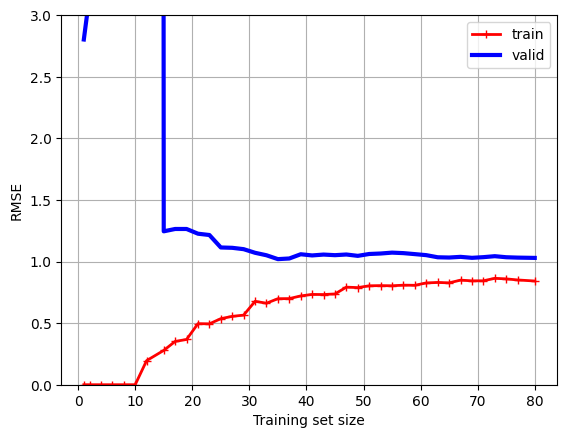

In [48]:
plot_learning_curve(tr_sizes, tr_errs, val_errs)

In [49]:
# now using polynomial features
from sklearn.pipeline import make_pipeline

poly_reg = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)

tr_sizes, tr_scores, val_scores = learning_curve(
    poly_reg,
    X, y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring='neg_root_mean_squared_error'
)

tr_errs = -tr_scores.mean(axis=1)
val_errs = -val_scores.mean(axis=1)

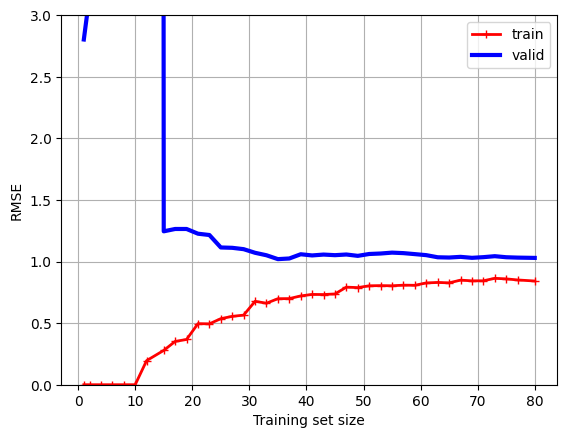

In [50]:
plot_learning_curve(tr_sizes, tr_errs, val_errs)

In [59]:
# regularization
# (important to scale the features before applying regularization)

# ridge regression/Tikhonov regularization
# in GD, add alpha/m * sum from i=1 to n(theta_i^2)
# in Closed form, (X^T x X + alpha * A)^-1 x X^T x y

from sklearn.linear_model import Ridge

m = 100
X = 2 * np.random.rand(m, 1)  # col vector
y = 4 + 3 * X + np.random.randn(m, 1)

# matrix factorization technique by Andre-Louis Cholesky
ridge_reg = Ridge(alpha=0.1, solver='cholesky')
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

# using SGD (specify l2 norm, but this doesn't divide by "m" so we do that too)
sgd_reg = SGDRegressor(penalty='l2', alpha=0.1/m, tol=None,
                      max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[[8.35657543]]
[8.35643877]


In [56]:
# lasso (least absolute shrinkage and selection operator) regression
# this performs feature selection too (least important features' weights become zero)
# 2 * alpha * sum from i=1 to n(|theta_i|)
# 2*alpha (and alpha/m) ensures optimal alpha is independent from training set size

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
print(lasso_reg.predict([[1.5]]))

# specify "l1" norm
sgd_reg = SGDRegressor(penalty='l1', alpha=0.1, tol=None,
                      max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[8.48701595]
[8.48783881]


In [57]:
# elastic net regression
# mixes the above two regularization
# r * (lasso) + (1-r) * (ridge)

from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
print(elastic_net.predict([[1.5]]))

[8.34549568]


In [58]:
# Ridge is a good default
# use ElasticNet or Lasso if you think only a few features are useful
# ElasticNet is preferred over Lasso, as Lasso behaves erratically when # features > # instances or when features are strongly correlated

In [62]:
# early stopping, another way to regularize

from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

X_p = 6 * np.random.rand(m, 1) - 3
y_p = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

split_point = round(0.8 * X_p.shape[0])
X_tr_p, y_tr_p, X_val_p, y_val_p = X_poly[:split_point], y_p[:split_point], X_poly[split_point:], y_p[split_point:]

preproc = make_pipeline(
    PolynomialFeatures(degree=90, include_bias=False),
    StandardScaler()
)

X_tr_prep_p = preproc.fit_transform(X_tr_p)
X_val_prep_p = preproc.transform(X_val_p)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_val_rmse = float('inf')

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_tr_prep_p, y_tr_p.ravel())  # incremental learning
    y_val_pred = sgd_reg.predict(X_val_prep_p)

    val_err = root_mean_squared_error(y_val_p, y_val_pred.ravel())
    if val_err < best_val_rmse:
        best_val_rmse = val_err
        # copies both hyperparams and learned params
        # sklearn.base.clone() only copies hyperparams
        best_model = deepcopy(sgd_reg)

In [65]:
best_model.predict(X_val_prep_p)

array([ -94.80519138, -102.51331447, -102.57374448,  -99.16270333,
       -102.37541427, -102.52042816, -100.89384108, -102.37010199,
        -92.46382392, -103.16813786,  -98.37472583, -101.24424722,
       -100.07471371, -102.95325803,  -99.75484682, -103.15631086,
       -103.1008235 , -103.11225815,  142.98804129,  -98.26345916])

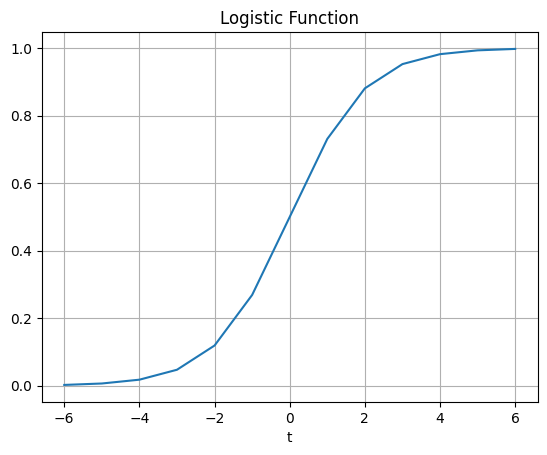

In [70]:
# logistic or logit regression
# logit function is inverse of logistic function
# logit(p) = log(p / (1-p)), logit AKA log-odds

plt.plot(np.arange(-6, 7), 1/(1 + np.exp(-np.arange(-6, 7))))
plt.grid()
plt.title('Logistic Function')
plt.xlabel('t')
plt.show()

In [71]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [73]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [76]:
iris.target.head(3)  # instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int32

In [77]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

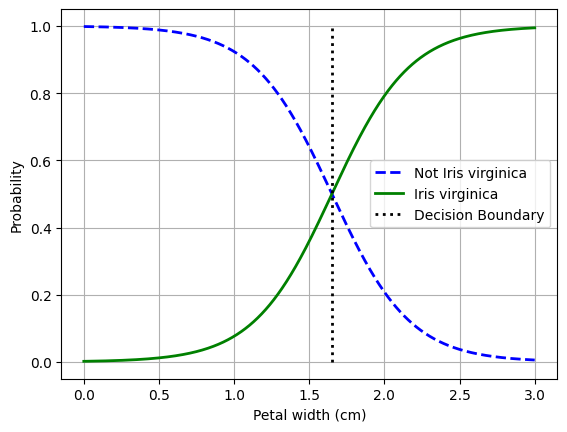

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[['petal width (cm)']].values
y = iris.target_names[iris.target] == "virginica"

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state=42)

lr = LogisticRegression(random_state=42)
lr.fit(X_tr, y_tr)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = lr.predict_proba(X_new)

# get first element with y_proba >= 0.5 (+ve class)
dec_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]


plt.plot(X_new, y_proba[:, 0], 'b--', linewidth=2, label='Not Iris virginica')
plt.plot(X_new, y_proba[:, 1], 'g-', linewidth=2, label='Iris virginica')
plt.plot([dec_boundary, dec_boundary], [0, 1], 'k:', linewidth=2, label='Decision Boundary')

plt.grid()
plt.legend()
plt.xlabel('Petal width (cm)')
plt.ylabel('Probability')

plt.show()

In [81]:
print(dec_boundary)
print(lr.predict([[1.7], [1.5]]))

1.6516516516516517
[ True False]


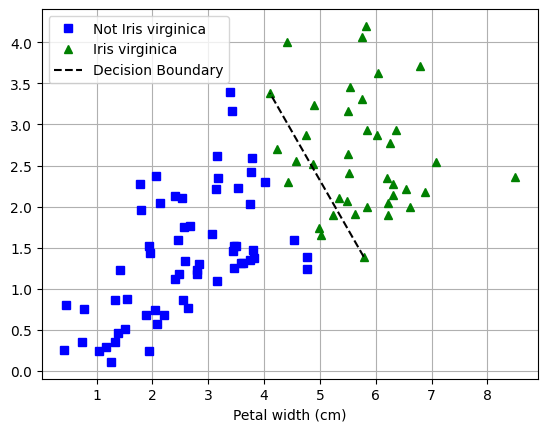

In [105]:
# with 2 features

X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target_names[iris.target] == "virginica"

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state=42)

lr = LogisticRegression(random_state=42)
lr.fit(X_tr, y_tr)

X_1_new = np.linspace(0.0, 6.0, 100).reshape(-1, 1) + np.abs(np.random.randn(100, 1))
X_2_new = np.linspace(0, 2, 100).reshape(-1, 1) + np.abs(np.random.randn(100, 1))

X_new = np.c_[X_1_new, X_2_new]
y_proba = lr.predict_proba(X_new)

# get first element with y_proba >= 0.5 (+ve class)
dec_boundary = X_new[y_proba[:, 1] >= 0.5][0:2, :]

is_iris = y_proba[:, 1] >= 0.5
plt.plot(X_1_new[~is_iris], X_2_new[~is_iris], 'bs', label='Not Iris virginica')
plt.plot(X_1_new[is_iris], X_2_new[is_iris], 'g^', label='Iris virginica')
plt.plot([dec_boundary[0, 0], dec_boundary[1, 0]], [dec_boundary[0, 1], dec_boundary[1, 1]], 'k--', label='Decision Boundary')

plt.grid()
plt.legend()
plt.xlabel('Petal length (cm)')
plt.xlabel('Petal width (cm)')

plt.show()

In [82]:
# for Logistic Regression, sklearn adds l2 penalty by default
# the hyperparam for regularization is C, which is inverse of alpha

In [84]:
# softmax regression

X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris['target']

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_tr, y_tr)

LogisticRegression(C=30, random_state=42)

In [85]:
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]).round(2))

[2]
[[0.   0.04 0.96]]
